In [18]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
    Resize, CenterCrop,
    ToPILImage,
    Normalize,
    RandomVerticalFlip,
    RandomRotation,
)

import torchvision.models as models
from torchvision import transforms

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

In [19]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 1.10.2+cu102
DEVICE: cuda


In [20]:
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.
    
    Args:
        s: Strength parameter.
    
    Returns:
        A color distortion transform.
    """

    image_transform = Compose([
                ToPILImage(),
                Resize(255),
                CenterCrop(224),
                RandomResizedCrop(224),
                RandomGrayscale(p=0.2),
                RandomHorizontalFlip(p=0.5),
                RandomVerticalFlip(p = 0.5),
                RandomApply([ColorJitter(0.4, 0.4, 0.4, 0.2)], p=0.8),      # random color jitter
                RandomApply([ GaussianBlur(kernel_size=[21,21])], p=0.5),   
                ToTensor(),
                Normalize(mean= [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225], 
                          inplace = True),
                ])
    

    return image_transform


# generate two views for an image
class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

In [22]:
labels = ['B', 'M']
labels.sort()
labelMap = {label: index for index, label in enumerate(labels)}
print(labelMap)

{'B': 0, 'M': 1}


In [23]:
class ContrastiveDataset(Dataset):

    def __init__(self, file_name, transform=None):
        
        self.list_images = []
        with open(file_name, 'r') as f:
            csvreader = csv.reader(f)
            for row in csvreader:
                self.list_images.append(row)
        
        self.transform = transform
    
    def __len__(self):
        return len(self.list_images)
    
    def __getitem__(self, index):
        img_name = self.list_images[index][0]
        image = io.imread(img_name)
        
        if self.transform:
            views = self.transform(image)
        return views
                

In [24]:
class ClassificationDataset(Dataset):
    def __init__(self, file_name, transform=None):
        self.list_images = []
       
        with open(file_name, 'r') as f:
            csvreader = csv.reader(f)
            for row in csvreader:
                self.list_images.append(row)
        self.transform = Compose([
            ToPILImage(),
            Resize(255),
            CenterCrop(224), 
            ToTensor(),
            Normalize(mean= [0.485, 0.456, 0.406], 
                      std = [0.229, 0.224, 0.225], 
                      inplace = True),
            ])
    
    
    def __len__(self):
        return len(self.list_images)
    
    def __getitem__(self, index):
        img_name = self.list_images[index][0]
        image = io.imread(img_name)
        
        class_name = img_name.split('/')[-1].split('_')[1]
        label = labelMap[class_name]
        
        if self.transform:
            class_image = self.transform(image)
        return class_image, label
    

In [25]:
base = '../Fold_1_5/'

In [26]:
output_shape = [224,224]
kernel_size = [21,21] # 10% of the output_shape

# base SimCLR data augmentation
base_transforms = get_complete_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)

# The custom transform
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)


train_ds = ContrastiveDataset(
    file_name= base + 'train_80.csv',
    transform=custom_transform
)

valid_ds = ContrastiveDataset(
    file_name= base + 'val_20.csv',
    transform=custom_transform
)


In [27]:
class_train_ds = ClassificationDataset(
    file_name= base + 'train_80.csv',
)

class_valid_ds = ClassificationDataset(
    file_name= base + 'val_20.csv'
)


In [28]:
print(len(class_train_ds), len(class_valid_ds))

6327 1582


In [29]:
print((class_train_ds[0]))

(tensor([[[0.6734, 0.7591, 0.9988,  ..., 0.4851, 0.9132, 0.8789],
         [1.1872, 0.7933, 0.6906,  ..., 0.6906, 0.7933, 0.7419],
         [1.3242, 0.8447, 0.5878,  ..., 1.0502, 1.0159, 0.8447],
         ...,
         [1.5810, 1.5982, 1.5982,  ..., 1.1872, 1.2899, 1.3070],
         [1.5810, 1.5982, 1.5982,  ..., 1.4954, 1.4440, 1.3242],
         [1.5982, 1.5810, 1.5810,  ..., 1.8893, 1.6838, 1.3242]],

        [[0.6779, 0.7654, 1.1506,  ..., 0.2402, 0.8704, 0.8880],
         [1.2381, 0.8529, 0.8529,  ..., 0.4503, 0.7304, 0.6604],
         [1.5007, 1.0280, 0.7304,  ..., 0.8354, 0.8354, 0.6429],
         ...,
         [2.0434, 2.0609, 2.0434,  ..., 0.6254, 0.8179, 0.8179],
         [2.0434, 2.0609, 2.0434,  ..., 0.9755, 0.9755, 0.8704],
         [2.0434, 2.0609, 2.0434,  ..., 1.3957, 1.2381, 0.8704]],

        [[0.9842, 1.0714, 1.2805,  ..., 1.0191, 1.5768, 1.4025],
         [1.5071, 1.1237, 0.9842,  ..., 1.1934, 1.3328, 1.1062],
         [1.7163, 1.2631, 0.9319,  ..., 1.5071, 1.4374, 1

In [30]:
print(len(train_ds), len(valid_ds))

6327 1582


In [31]:
print((train_ds[0]))

[tensor([[[2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
         [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
         [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
         ...,
         [2.2318, 2.2147, 2.2147,  ..., 2.2318, 2.2318, 2.2318],
         [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
         [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318]],

        [[2.4111, 2.4111, 2.4111,  ..., 2.1485, 1.9384, 2.0609],
         [2.4111, 2.4111, 2.4111,  ..., 2.2185, 2.0959, 2.2360],
         [2.4111, 2.4111, 2.4111,  ..., 2.3761, 2.2710, 2.2010],
         ...,
         [2.3761, 2.3585, 2.3410,  ..., 1.8508, 1.7633, 1.8859],
         [2.4111, 2.4111, 2.4111,  ..., 2.3235, 2.3060, 2.3235],
         [2.4111, 2.4111, 2.4111,  ..., 2.3410, 2.4111, 2.4111]],

        [[2.6226, 2.6226, 2.6226,  ..., 2.6051, 2.6051, 2.6051],
         [2.6226, 2.6226, 2.6226,  ..., 2.6226, 2.6051, 2.6226],
         [2.6226, 2.6226, 2.6226,  ..., 2.6226, 2.6051, 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

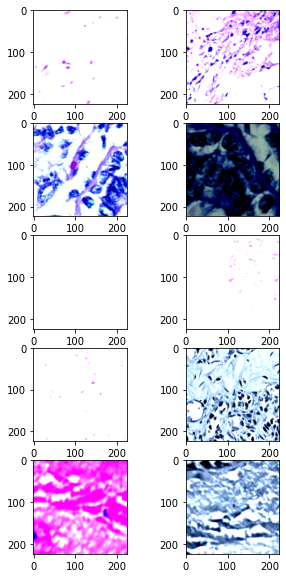

In [32]:
plt.figure(figsize=(5,10))
def view_data(ds, index):
    for i in range(1,6):
        images = ds[i]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(train_ds, 20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

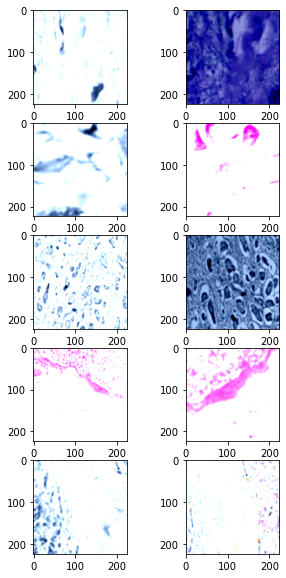

In [33]:
plt.figure(figsize=(5,10))
def view_data(ds, index):
    for i in range(1,6):
        images = ds[i]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(valid_ds, 20)

In [34]:
BATCH_SIZE = 256

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)
       
valid_dl = torch.utils.data.DataLoader(
    valid_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)


In [35]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x
    
class SimCLRContrastive(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.encoder = backbone
        
        self.projection = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128)
        )
        
    def forward(self, x):

        x = torch.cat(x, dim=0)
        encoding = self.encoder(x)

        projection = self.projection(encoding) 
        return projection

In [36]:
backbone = torchvision.models.resnet50(pretrained = True)
backbone.fc = Identity()

In [37]:

simclr_model = SimCLRContrastive(backbone).to(DEVICE)                       # network model
cont_criterion = nn.CrossEntropyLoss().to(DEVICE)                # loss
cont_optimizer = torch.optim.Adam(simclr_model.parameters(), weight_decay= (10**-6))     # optimizer

In [38]:
simclr_model.encoder

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

# contrastive loss
def cont_loss(features, temp):
    """
    The NTxent Loss.
    
    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch
    
    Returns:
        the NTxent loss
    """
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp
    return logits, labels

In [23]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [24]:
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [39]:
root = 'Fold_1_5'

In [40]:

import torch
from torch import nn
from torch.optim.optimizer import Optimizer, required

class LARS(Optimizer):
    r"""Extends SGD in PyTorch with LARS scaling from the paper
    `Large batch training of Convolutional Networks <https://arxiv.org/pdf/1708.03888.pdf>`_.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
        trust_coefficient (float, optional): trust coefficient for computing LR (default: 0.001)
        eps (float, optional): eps for division denominator (default: 1e-8)

    Example:
        >>> model = nn.Linear(10, 1)
        >>> optimizer = LARS(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> # loss_fn(model(input), target).backward()
        >>> optimizer.step()

    .. note::
        The application of momentum in the SGD part is modified according to
        the PyTorch standards. LARS scaling fits into the equation in the
        following fashion.

        .. math::
            \begin{aligned}
                g_{t+1} & = \text{lars\_lr} * (\beta * p_{t} + g_{t+1}), \\
                v_{t+1} & = \mu * v_{t} + g_{t+1}, \\
                p_{t+1} & = p_{t} - \text{lr} * v_{t+1},
            \end{aligned}

        where :math:`p`, :math:`g`, :math:`v`, :math:`\mu` and :math:`\beta` denote the
        parameters, gradient, velocity, momentum, and weight decay respectively.
        The :math:`lars_lr` is defined by Eq. 6 in the paper.
        The Nesterov version is analogously modified.

    .. warning::
        Parameters with weight decay set to 0 will automatically be excluded from
        layer-wise LR scaling. This is to ensure consistency with papers like SimCLR
        and BYOL.
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum: float = 0,
        dampening: float = 0,
        weight_decay: float = 0,
        nesterov: bool = False,
        trust_coefficient: float = 0.001,
        eps: float = 1e-8,
    ):
        if lr is not required and lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if momentum < 0.0:
            raise ValueError(f"Invalid momentum value: {momentum}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")

        self.eps = eps
        self.trust_coefficient = trust_coefficient

        super().__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)

        for group in self.param_groups:
            group.setdefault("nesterov", False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        # exclude scaling for params with 0 weight decay
        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            dampening = group["dampening"]
            nesterov = group["nesterov"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                d_p = p.grad
                p_norm = torch.norm(p.data)
                g_norm = torch.norm(p.grad.data)

                # lars scaling + weight decay part
                if weight_decay != 0:
                    if p_norm != 0 and g_norm != 0:
                        lars_lr = p_norm / (g_norm + p_norm * weight_decay + self.eps)
                        lars_lr *= self.trust_coefficient

                        d_p = d_p.add(p, alpha=weight_decay)
                        d_p *= lars_lr

                # sgd part
                if momentum != 0:
                    param_state = self.state[p]
                    if "momentum_buffer" not in param_state:
                        buf = param_state["momentum_buffer"] = torch.clone(d_p).detach()
                    else:
                        buf = param_state["momentum_buffer"]
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                p.add_(d_p, alpha=-group["lr"])

        return loss


In [ ]:
backbone = torchvision.models.resnet50(pretrained = True)
backbone.fc = Identity()

# lr = 0.3*(BATCH_SIZE)/256
lr = 0.075*(BATCH_SIZE**0.5)

simclr_model = SimCLRContrastive(backbone).to(DEVICE)                       
cont_criterion = nn.CrossEntropyLoss().to(DEVICE) 

cont_optimizer = LARS(simclr_model.parameters(), lr = lr, weight_decay= (10**-6))     

scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(cont_optimizer, T_max=1000, 
                                                     eta_min=10**-5, verbose=True)


In [45]:
from tqdm import tqdm
epochs = 100

for epoch in range(epochs):
    train_cont_losses = list()
    valid_cont_losses = list()
    simclr_model.train()
    for views in tqdm(train_dl):
        projections = simclr_model([view.to(DEVICE) for view in views])
        logits, labels = cont_loss(projections, temp=0.1)
        loss = cont_criterion(logits, labels)
        cont_optimizer.zero_grad()
        loss.backward()
        cont_optimizer.step()
    
        train_cont_losses.append(loss.item())
  
    mean_loss = torch.tensor(train_cont_losses).mean()
    scheduler.step()
    
    if (epoch+1)%10==0:
        checkpoints = { 
                'model': simclr_model.state_dict(), 
                'contrastive_optimizer': cont_optimizer.state_dict(),
                'epochs': epoch + 1,
              }
        torch.save(checkpoints,f'saved_models/SimCLR-1-{root}-Contrastive-epoch-{epoch+1}.pth.tar' )
        print(f"saved checkpoint for epoch {epoch + 1}")
        
    print(f'Epoch {epoch + 1}')
    print(f'contrastive training loss: {mean_loss:.5f}')
    
    simclr_model.eval()
    for views in tqdm(valid_dl):
        with torch.no_grad():
            projections = simclr_model([view.to(DEVICE) for view in views])
        logits, labels = cont_loss(projections, temp=0.1)
        loss = cont_criterion(logits, labels)
        
        valid_cont_losses.append(loss.item())
  
    mean_loss = torch.tensor(valid_cont_losses).mean()
    print(f'contrastive validation loss: {mean_loss:.5f}\n\n')


100%|███████████████████████████████████████████| 24/24 [02:14<00:00,  5.59s/it]


Adjusting learning rate of group 0 to 1.2000e+00.
Epoch 1
contrastive training loss: 4.66184


100%|█████████████████████████████████████████████| 6/6 [00:28<00:00,  4.82s/it]


contrastive validation loss: 3.65050




100%|███████████████████████████████████████████| 24/24 [01:16<00:00,  3.18s/it]


Adjusting learning rate of group 0 to 1.2000e+00.
Epoch 2
contrastive training loss: 3.06256


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.20s/it]


contrastive validation loss: 2.84431




100%|███████████████████████████████████████████| 24/24 [01:17<00:00,  3.24s/it]


Adjusting learning rate of group 0 to 1.2000e+00.
Epoch 3
contrastive training loss: 2.41513


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.15s/it]


contrastive validation loss: 2.39898




100%|███████████████████████████████████████████| 24/24 [01:15<00:00,  3.16s/it]


Adjusting learning rate of group 0 to 1.2000e+00.
Epoch 4
contrastive training loss: 2.03517


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.34s/it]


contrastive validation loss: 2.20360




100%|███████████████████████████████████████████| 24/24 [01:14<00:00,  3.09s/it]


Adjusting learning rate of group 0 to 1.1999e+00.
Epoch 5
contrastive training loss: 1.73229


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.27s/it]


contrastive validation loss: 2.04722




100%|███████████████████████████████████████████| 24/24 [01:16<00:00,  3.18s/it]


Adjusting learning rate of group 0 to 1.1999e+00.
Epoch 6
contrastive training loss: 1.56513


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.24s/it]


contrastive validation loss: 2.34504




100%|███████████████████████████████████████████| 24/24 [01:14<00:00,  3.11s/it]


Adjusting learning rate of group 0 to 1.1999e+00.
Epoch 7
contrastive training loss: 1.42691


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.24s/it]


contrastive validation loss: 1.55962




100%|███████████████████████████████████████████| 24/24 [01:14<00:00,  3.09s/it]


Adjusting learning rate of group 0 to 1.1998e+00.
Epoch 8
contrastive training loss: 1.30875


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.35s/it]


contrastive validation loss: 1.47217




100%|███████████████████████████████████████████| 24/24 [01:17<00:00,  3.22s/it]


Adjusting learning rate of group 0 to 1.1998e+00.
Epoch 9
contrastive training loss: 1.21551


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.15s/it]


contrastive validation loss: 1.44541




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.08s/it]


Adjusting learning rate of group 0 to 1.1997e+00.
saved checkpoint for epoch 10
Epoch 10
contrastive training loss: 1.14654


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.19s/it]


contrastive validation loss: 1.24001




100%|███████████████████████████████████████████| 24/24 [01:17<00:00,  3.23s/it]


Adjusting learning rate of group 0 to 1.1996e+00.
Epoch 11
contrastive training loss: 1.11542


100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.53s/it]


contrastive validation loss: 1.17811




100%|███████████████████████████████████████████| 24/24 [01:12<00:00,  3.03s/it]


Adjusting learning rate of group 0 to 1.1996e+00.
Epoch 12
contrastive training loss: 1.00814


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.42s/it]


contrastive validation loss: 1.31426




100%|███████████████████████████████████████████| 24/24 [01:15<00:00,  3.16s/it]


Adjusting learning rate of group 0 to 1.1995e+00.
Epoch 13
contrastive training loss: 0.99359


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.12s/it]


contrastive validation loss: 1.25735




100%|███████████████████████████████████████████| 24/24 [01:15<00:00,  3.15s/it]


Adjusting learning rate of group 0 to 1.1994e+00.
Epoch 14
contrastive training loss: 0.96264


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.27s/it]


contrastive validation loss: 1.06815




100%|███████████████████████████████████████████| 24/24 [01:12<00:00,  3.01s/it]


Adjusting learning rate of group 0 to 1.1993e+00.
Epoch 15
contrastive training loss: 0.92178


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.24s/it]


contrastive validation loss: 1.12285




100%|███████████████████████████████████████████| 24/24 [01:14<00:00,  3.12s/it]


Adjusting learning rate of group 0 to 1.1992e+00.
Epoch 16
contrastive training loss: 0.86796


100%|█████████████████████████████████████████████| 6/6 [00:23<00:00,  3.98s/it]


contrastive validation loss: 0.98556




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.06s/it]


Adjusting learning rate of group 0 to 1.1991e+00.
Epoch 17
contrastive training loss: 0.84769


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.18s/it]


contrastive validation loss: 1.23364




100%|███████████████████████████████████████████| 24/24 [01:17<00:00,  3.24s/it]


Adjusting learning rate of group 0 to 1.1990e+00.
Epoch 18
contrastive training loss: 0.79174


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.02s/it]


contrastive validation loss: 1.28134




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.08s/it]


Adjusting learning rate of group 0 to 1.1989e+00.
Epoch 19
contrastive training loss: 0.76798


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.35s/it]


contrastive validation loss: 1.58640




100%|███████████████████████████████████████████| 24/24 [01:14<00:00,  3.12s/it]


Adjusting learning rate of group 0 to 1.1988e+00.
saved checkpoint for epoch 20
Epoch 20
contrastive training loss: 0.77354


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.27s/it]


contrastive validation loss: 0.94240




100%|███████████████████████████████████████████| 24/24 [01:14<00:00,  3.10s/it]


Adjusting learning rate of group 0 to 1.1987e+00.
Epoch 21
contrastive training loss: 0.75918


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.38s/it]


contrastive validation loss: 0.97230




100%|███████████████████████████████████████████| 24/24 [01:18<00:00,  3.27s/it]


Adjusting learning rate of group 0 to 1.1986e+00.
Epoch 22
contrastive training loss: 0.68736


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.22s/it]


contrastive validation loss: 1.24640




100%|███████████████████████████████████████████| 24/24 [01:16<00:00,  3.18s/it]


Adjusting learning rate of group 0 to 1.1984e+00.
Epoch 23
contrastive training loss: 0.66031


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.21s/it]


contrastive validation loss: 0.79022




100%|███████████████████████████████████████████| 24/24 [01:18<00:00,  3.29s/it]


Adjusting learning rate of group 0 to 1.1983e+00.
Epoch 24
contrastive training loss: 0.64839


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.06s/it]


contrastive validation loss: 0.91407




100%|███████████████████████████████████████████| 24/24 [01:19<00:00,  3.30s/it]


Adjusting learning rate of group 0 to 1.1982e+00.
Epoch 25
contrastive training loss: 0.66341


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.23s/it]


contrastive validation loss: 0.79079




100%|███████████████████████████████████████████| 24/24 [01:15<00:00,  3.15s/it]


Adjusting learning rate of group 0 to 1.1980e+00.
Epoch 26
contrastive training loss: 0.67154


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.13s/it]


contrastive validation loss: 1.53312




100%|███████████████████████████████████████████| 24/24 [01:12<00:00,  3.03s/it]


Adjusting learning rate of group 0 to 1.1978e+00.
Epoch 27
contrastive training loss: 0.65397


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.17s/it]


contrastive validation loss: 0.86716




100%|███████████████████████████████████████████| 24/24 [01:14<00:00,  3.10s/it]


Adjusting learning rate of group 0 to 1.1977e+00.
Epoch 28
contrastive training loss: 0.64460


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.30s/it]


contrastive validation loss: 1.04046




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.07s/it]


Adjusting learning rate of group 0 to 1.1975e+00.
Epoch 29
contrastive training loss: 0.60404


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.15s/it]


contrastive validation loss: 0.95572




100%|███████████████████████████████████████████| 24/24 [01:16<00:00,  3.21s/it]


Adjusting learning rate of group 0 to 1.1973e+00.
saved checkpoint for epoch 30
Epoch 30
contrastive training loss: 0.63042


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.42s/it]


contrastive validation loss: 0.76310




100%|███████████████████████████████████████████| 24/24 [01:21<00:00,  3.40s/it]


Adjusting learning rate of group 0 to 1.1972e+00.
Epoch 31
contrastive training loss: 0.60291


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.32s/it]


contrastive validation loss: 0.68992




100%|███████████████████████████████████████████| 24/24 [01:20<00:00,  3.37s/it]


Adjusting learning rate of group 0 to 1.1970e+00.
Epoch 32
contrastive training loss: 0.57182


100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.52s/it]


contrastive validation loss: 0.78919




100%|███████████████████████████████████████████| 24/24 [01:12<00:00,  3.04s/it]


Adjusting learning rate of group 0 to 1.1968e+00.
Epoch 33
contrastive training loss: 0.56946


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.29s/it]


contrastive validation loss: 0.79889




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.05s/it]


Adjusting learning rate of group 0 to 1.1966e+00.
Epoch 34
contrastive training loss: 0.54375


100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.51s/it]


contrastive validation loss: 0.66560




100%|███████████████████████████████████████████| 24/24 [01:20<00:00,  3.34s/it]


Adjusting learning rate of group 0 to 1.1964e+00.
Epoch 35
contrastive training loss: 0.54927


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.16s/it]


contrastive validation loss: 0.69487




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.08s/it]


Adjusting learning rate of group 0 to 1.1962e+00.
Epoch 36
contrastive training loss: 0.56359


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.38s/it]


contrastive validation loss: 0.68075




100%|███████████████████████████████████████████| 24/24 [01:17<00:00,  3.23s/it]


Adjusting learning rate of group 0 to 1.1960e+00.
Epoch 37
contrastive training loss: 0.53249


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.27s/it]


contrastive validation loss: 0.71867




100%|███████████████████████████████████████████| 24/24 [01:12<00:00,  3.04s/it]


Adjusting learning rate of group 0 to 1.1957e+00.
Epoch 38
contrastive training loss: 0.55538


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.39s/it]


contrastive validation loss: 0.67117




100%|███████████████████████████████████████████| 24/24 [01:19<00:00,  3.31s/it]


Adjusting learning rate of group 0 to 1.1955e+00.
Epoch 39
contrastive training loss: 0.51936


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.22s/it]


contrastive validation loss: 0.78694




100%|███████████████████████████████████████████| 24/24 [01:19<00:00,  3.33s/it]


Adjusting learning rate of group 0 to 1.1953e+00.
saved checkpoint for epoch 40
Epoch 40
contrastive training loss: 0.51364


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.32s/it]


contrastive validation loss: 0.64423




100%|███████████████████████████████████████████| 24/24 [01:16<00:00,  3.20s/it]


Adjusting learning rate of group 0 to 1.1950e+00.
Epoch 41
contrastive training loss: 0.52628


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.22s/it]


contrastive validation loss: 0.78274




100%|███████████████████████████████████████████| 24/24 [01:19<00:00,  3.32s/it]


Adjusting learning rate of group 0 to 1.1948e+00.
Epoch 42
contrastive training loss: 0.50799


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.13s/it]


contrastive validation loss: 1.10810




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.05s/it]


Adjusting learning rate of group 0 to 1.1945e+00.
Epoch 43
contrastive training loss: 0.47656


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.08s/it]


contrastive validation loss: 0.77084




100%|███████████████████████████████████████████| 24/24 [01:14<00:00,  3.09s/it]


Adjusting learning rate of group 0 to 1.1943e+00.
Epoch 44
contrastive training loss: 0.47393


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.25s/it]


contrastive validation loss: 0.67403




100%|███████████████████████████████████████████| 24/24 [01:12<00:00,  3.03s/it]


Adjusting learning rate of group 0 to 1.1940e+00.
Epoch 45
contrastive training loss: 0.47455


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.48s/it]


contrastive validation loss: 0.64279




100%|███████████████████████████████████████████| 24/24 [01:12<00:00,  3.04s/it]


Adjusting learning rate of group 0 to 1.1937e+00.
Epoch 46
contrastive training loss: 0.46411


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.29s/it]


contrastive validation loss: 0.87429




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.08s/it]


Adjusting learning rate of group 0 to 1.1935e+00.
Epoch 47
contrastive training loss: 0.47136


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.33s/it]


contrastive validation loss: 0.90888




100%|███████████████████████████████████████████| 24/24 [01:14<00:00,  3.11s/it]


Adjusting learning rate of group 0 to 1.1932e+00.
Epoch 48
contrastive training loss: 0.47108


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.38s/it]


contrastive validation loss: 0.57443




100%|███████████████████████████████████████████| 24/24 [01:12<00:00,  3.01s/it]


Adjusting learning rate of group 0 to 1.1929e+00.
Epoch 49
contrastive training loss: 0.45437


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.41s/it]


contrastive validation loss: 0.73401




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.08s/it]


Adjusting learning rate of group 0 to 1.1926e+00.
saved checkpoint for epoch 50
Epoch 50
contrastive training loss: 0.45172


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.15s/it]


contrastive validation loss: 0.64027




100%|███████████████████████████████████████████| 24/24 [01:11<00:00,  2.99s/it]


Adjusting learning rate of group 0 to 1.1923e+00.
Epoch 51
contrastive training loss: 0.44994


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.33s/it]


contrastive validation loss: 0.62039




100%|███████████████████████████████████████████| 24/24 [01:15<00:00,  3.13s/it]


Adjusting learning rate of group 0 to 1.1920e+00.
Epoch 52
contrastive training loss: 0.42015


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.23s/it]


contrastive validation loss: 0.99580




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.08s/it]


Adjusting learning rate of group 0 to 1.1917e+00.
Epoch 53
contrastive training loss: 0.44592


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.50s/it]


contrastive validation loss: 0.58382




100%|███████████████████████████████████████████| 24/24 [01:10<00:00,  2.95s/it]


Adjusting learning rate of group 0 to 1.1914e+00.
Epoch 54
contrastive training loss: 0.43209


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.07s/it]


contrastive validation loss: 0.57914




100%|███████████████████████████████████████████| 24/24 [01:15<00:00,  3.16s/it]


Adjusting learning rate of group 0 to 1.1911e+00.
Epoch 55
contrastive training loss: 0.45166


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.30s/it]


contrastive validation loss: 0.64690




100%|███████████████████████████████████████████| 24/24 [01:16<00:00,  3.21s/it]


Adjusting learning rate of group 0 to 1.1907e+00.
Epoch 56
contrastive training loss: 0.44385


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.04s/it]


contrastive validation loss: 0.61415




100%|███████████████████████████████████████████| 24/24 [01:17<00:00,  3.22s/it]


Adjusting learning rate of group 0 to 1.1904e+00.
Epoch 57
contrastive training loss: 0.43229


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.18s/it]


contrastive validation loss: 0.91223




100%|███████████████████████████████████████████| 24/24 [01:15<00:00,  3.14s/it]


Adjusting learning rate of group 0 to 1.1901e+00.
Epoch 58
contrastive training loss: 0.39961


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.34s/it]


contrastive validation loss: 0.58922




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.05s/it]


Adjusting learning rate of group 0 to 1.1897e+00.
Epoch 59
contrastive training loss: 0.40935


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.26s/it]


contrastive validation loss: 0.52172




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.06s/it]


Adjusting learning rate of group 0 to 1.1894e+00.
saved checkpoint for epoch 60
Epoch 60
contrastive training loss: 0.42862


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.44s/it]


contrastive validation loss: 0.62014




100%|███████████████████████████████████████████| 24/24 [01:17<00:00,  3.23s/it]


Adjusting learning rate of group 0 to 1.1890e+00.
Epoch 61
contrastive training loss: 0.38962


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.30s/it]


contrastive validation loss: 0.72067




100%|███████████████████████████████████████████| 24/24 [01:15<00:00,  3.16s/it]


Adjusting learning rate of group 0 to 1.1887e+00.
Epoch 62
contrastive training loss: 0.40248


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.38s/it]


contrastive validation loss: 0.51916




100%|███████████████████████████████████████████| 24/24 [01:15<00:00,  3.14s/it]


Adjusting learning rate of group 0 to 1.1883e+00.
Epoch 63
contrastive training loss: 0.38451


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.18s/it]


contrastive validation loss: 0.79715




100%|███████████████████████████████████████████| 24/24 [01:12<00:00,  3.03s/it]


Adjusting learning rate of group 0 to 1.1879e+00.
Epoch 64
contrastive training loss: 0.38061


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.38s/it]


contrastive validation loss: 0.63767




100%|███████████████████████████████████████████| 24/24 [01:17<00:00,  3.22s/it]


Adjusting learning rate of group 0 to 1.1875e+00.
Epoch 65
contrastive training loss: 0.43297


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.27s/it]


contrastive validation loss: 0.60221




100%|███████████████████████████████████████████| 24/24 [01:16<00:00,  3.18s/it]


Adjusting learning rate of group 0 to 1.1871e+00.
Epoch 66
contrastive training loss: 0.37485


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.07s/it]


contrastive validation loss: 0.53795




100%|███████████████████████████████████████████| 24/24 [01:19<00:00,  3.32s/it]


Adjusting learning rate of group 0 to 1.1868e+00.
Epoch 67
contrastive training loss: 0.41240


100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.63s/it]


contrastive validation loss: 0.59513




100%|███████████████████████████████████████████| 24/24 [01:12<00:00,  3.04s/it]


Adjusting learning rate of group 0 to 1.1864e+00.
Epoch 68
contrastive training loss: 0.36794


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.26s/it]


contrastive validation loss: 0.51135




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.05s/it]


Adjusting learning rate of group 0 to 1.1860e+00.
Epoch 69
contrastive training loss: 0.39604


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.18s/it]


contrastive validation loss: 0.57912




100%|███████████████████████████████████████████| 24/24 [01:16<00:00,  3.19s/it]


Adjusting learning rate of group 0 to 1.1856e+00.
saved checkpoint for epoch 70
Epoch 70
contrastive training loss: 0.38647


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.17s/it]


contrastive validation loss: 0.66165




100%|███████████████████████████████████████████| 24/24 [01:14<00:00,  3.09s/it]


Adjusting learning rate of group 0 to 1.1851e+00.
Epoch 71
contrastive training loss: 0.37153


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.22s/it]


contrastive validation loss: 0.78333




100%|███████████████████████████████████████████| 24/24 [01:14<00:00,  3.10s/it]


Adjusting learning rate of group 0 to 1.1847e+00.
Epoch 72
contrastive training loss: 0.35772


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.13s/it]


contrastive validation loss: 0.64655




100%|███████████████████████████████████████████| 24/24 [01:16<00:00,  3.19s/it]


Adjusting learning rate of group 0 to 1.1843e+00.
Epoch 73
contrastive training loss: 0.37418


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.48s/it]


contrastive validation loss: 0.74814




100%|███████████████████████████████████████████| 24/24 [01:12<00:00,  3.01s/it]


Adjusting learning rate of group 0 to 1.1839e+00.
Epoch 74
contrastive training loss: 0.37544


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.21s/it]


contrastive validation loss: 0.60592




100%|███████████████████████████████████████████| 24/24 [01:16<00:00,  3.19s/it]


Adjusting learning rate of group 0 to 1.1834e+00.
Epoch 75
contrastive training loss: 0.37290


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.31s/it]


contrastive validation loss: 0.87714




100%|███████████████████████████████████████████| 24/24 [01:16<00:00,  3.19s/it]


Adjusting learning rate of group 0 to 1.1830e+00.
Epoch 76
contrastive training loss: 0.35919


100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.57s/it]


contrastive validation loss: 0.46880




100%|███████████████████████████████████████████| 24/24 [01:15<00:00,  3.16s/it]


Adjusting learning rate of group 0 to 1.1825e+00.
Epoch 77
contrastive training loss: 0.36678


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.13s/it]


contrastive validation loss: 0.53978




100%|███████████████████████████████████████████| 24/24 [01:15<00:00,  3.15s/it]


Adjusting learning rate of group 0 to 1.1821e+00.
Epoch 78
contrastive training loss: 0.35565


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.36s/it]


contrastive validation loss: 0.77208




100%|███████████████████████████████████████████| 24/24 [01:17<00:00,  3.24s/it]


Adjusting learning rate of group 0 to 1.1816e+00.
Epoch 79
contrastive training loss: 0.36641


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.20s/it]


contrastive validation loss: 0.52221




100%|███████████████████████████████████████████| 24/24 [01:17<00:00,  3.25s/it]


Adjusting learning rate of group 0 to 1.1812e+00.
saved checkpoint for epoch 80
Epoch 80
contrastive training loss: 0.33929


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.36s/it]


contrastive validation loss: 0.48000




100%|███████████████████████████████████████████| 24/24 [01:12<00:00,  3.00s/it]


Adjusting learning rate of group 0 to 1.1807e+00.
Epoch 81
contrastive training loss: 0.30975


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.33s/it]


contrastive validation loss: 0.61098




100%|███████████████████████████████████████████| 24/24 [01:15<00:00,  3.16s/it]


Adjusting learning rate of group 0 to 1.1802e+00.
Epoch 82
contrastive training loss: 0.33439


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.21s/it]


contrastive validation loss: 0.64717




100%|███████████████████████████████████████████| 24/24 [01:14<00:00,  3.09s/it]


Adjusting learning rate of group 0 to 1.1797e+00.
Epoch 83
contrastive training loss: 0.34172


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.03s/it]


contrastive validation loss: 0.51377




100%|███████████████████████████████████████████| 24/24 [01:17<00:00,  3.25s/it]


Adjusting learning rate of group 0 to 1.1792e+00.
Epoch 84
contrastive training loss: 0.33840


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.31s/it]


contrastive validation loss: 0.58961




100%|███████████████████████████████████████████| 24/24 [01:16<00:00,  3.18s/it]


Adjusting learning rate of group 0 to 1.1787e+00.
Epoch 85
contrastive training loss: 0.34752


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.29s/it]


contrastive validation loss: 0.43749




100%|███████████████████████████████████████████| 24/24 [01:17<00:00,  3.24s/it]


Adjusting learning rate of group 0 to 1.1782e+00.
Epoch 86
contrastive training loss: 0.33195


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.20s/it]


contrastive validation loss: 0.54796




100%|███████████████████████████████████████████| 24/24 [01:19<00:00,  3.31s/it]


Adjusting learning rate of group 0 to 1.1777e+00.
Epoch 87
contrastive training loss: 0.34104


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.24s/it]


contrastive validation loss: 0.51662




100%|███████████████████████████████████████████| 24/24 [01:17<00:00,  3.23s/it]


Adjusting learning rate of group 0 to 1.1772e+00.
Epoch 88
contrastive training loss: 0.34901


100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.35s/it]


contrastive validation loss: 0.51580




100%|███████████████████████████████████████████| 24/24 [01:19<00:00,  3.30s/it]


Adjusting learning rate of group 0 to 1.1767e+00.
Epoch 89
contrastive training loss: 0.33388


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.29s/it]


contrastive validation loss: 0.53280




100%|███████████████████████████████████████████| 24/24 [01:14<00:00,  3.09s/it]


Adjusting learning rate of group 0 to 1.1762e+00.
saved checkpoint for epoch 90
Epoch 90
contrastive training loss: 0.31046


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.27s/it]


contrastive validation loss: 0.55280




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.05s/it]


Adjusting learning rate of group 0 to 1.1756e+00.
Epoch 91
contrastive training loss: 0.31382


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.22s/it]


contrastive validation loss: 0.57021




100%|███████████████████████████████████████████| 24/24 [01:17<00:00,  3.25s/it]


Adjusting learning rate of group 0 to 1.1751e+00.
Epoch 92
contrastive training loss: 0.32672


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.14s/it]


contrastive validation loss: 0.44371




100%|███████████████████████████████████████████| 24/24 [01:12<00:00,  3.04s/it]


Adjusting learning rate of group 0 to 1.1746e+00.
Epoch 93
contrastive training loss: 0.34309


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.24s/it]


contrastive validation loss: 0.48142




100%|███████████████████████████████████████████| 24/24 [01:12<00:00,  3.01s/it]


Adjusting learning rate of group 0 to 1.1740e+00.
Epoch 94
contrastive training loss: 0.30275


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.04s/it]


contrastive validation loss: 0.53526




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.04s/it]


Adjusting learning rate of group 0 to 1.1735e+00.
Epoch 95
contrastive training loss: 0.32810


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.33s/it]


contrastive validation loss: 0.62574




100%|███████████████████████████████████████████| 24/24 [01:16<00:00,  3.20s/it]


Adjusting learning rate of group 0 to 1.1729e+00.
Epoch 96
contrastive training loss: 0.33327


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.08s/it]


contrastive validation loss: 1.61362




100%|███████████████████████████████████████████| 24/24 [01:14<00:00,  3.11s/it]


Adjusting learning rate of group 0 to 1.1724e+00.
Epoch 97
contrastive training loss: 0.32396


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.05s/it]


contrastive validation loss: 1.41122




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.08s/it]


Adjusting learning rate of group 0 to 1.1718e+00.
Epoch 98
contrastive training loss: 0.31069


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.04s/it]


contrastive validation loss: 0.50901




100%|███████████████████████████████████████████| 24/24 [01:18<00:00,  3.28s/it]


Adjusting learning rate of group 0 to 1.1712e+00.
Epoch 99
contrastive training loss: 0.30923


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.18s/it]


contrastive validation loss: 0.47640




100%|███████████████████████████████████████████| 24/24 [01:13<00:00,  3.07s/it]


Adjusting learning rate of group 0 to 1.1706e+00.
saved checkpoint for epoch 100
Epoch 100
contrastive training loss: 0.31346


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.22s/it]

contrastive validation loss: 0.51184




In [41]:
checkpoint = torch.load(f'saved_models/SimCLR-1-{root}-Contrastive-epoch-100.pth.tar' )
simclr_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [42]:
class SimCLRClassifier(nn.Module):
    def __init__(self,backbone):
        super().__init__()
        self.encoder = backbone
        self.linear = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 2))
                           
    def forward(self, x):
        encoding = self.encoder(x).flatten(start_dim=1)
        classification = self.linear(encoding)
        return classification

In [43]:
classifierModel = SimCLRClassifier(backbone).to(DEVICE)

In [44]:
# warm up

In [45]:
for param in classifierModel.encoder.parameters():
    param.requires_grad = False

In [46]:
print(classifierModel.linear[0].weight.requires_grad)
for param in classifierModel.encoder.parameters():
    print(param.requires_grad)

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [47]:
# Building the classification data loader
class_train_ds = ClassificationDataset(
    file_name= base + 'train_80.csv',
)
class_valid_ds = ClassificationDataset(
    file_name= base + 'val_20.csv',
)



In [48]:
print(class_train_ds[16])

(tensor([[[1.3755, 1.3584, 1.3584,  ..., 1.2899, 1.2899, 1.2899],
         [1.3584, 1.3413, 1.3413,  ..., 1.2899, 1.2728, 1.2899],
         [1.3584, 1.3242, 1.3242,  ..., 1.2899, 1.2899, 1.3070],
         ...,
         [0.8104, 0.7933, 1.0331,  ..., 1.3242, 1.3413, 1.2899],
         [0.7591, 0.8447, 1.1187,  ..., 1.3755, 1.4098, 1.3584],
         [0.7591, 0.9303, 1.2214,  ..., 1.3584, 1.4269, 1.3927]],

        [[1.6408, 1.6408, 1.6057,  ..., 1.6232, 1.6232, 1.6057],
         [1.6057, 1.6057, 1.6057,  ..., 1.6232, 1.6232, 1.6232],
         [1.6232, 1.6057, 1.5882,  ..., 1.6583, 1.6408, 1.6232],
         ...,
         [1.0105, 0.9580, 1.1681,  ..., 1.6408, 1.6933, 1.6232],
         [0.9230, 0.9930, 1.2556,  ..., 1.7108, 1.7283, 1.6232],
         [0.9055, 1.0805, 1.3606,  ..., 1.6583, 1.7283, 1.6758]],

        [[1.7337, 1.7337, 1.7337,  ..., 1.6640, 1.6640, 1.6640],
         [1.7163, 1.7163, 1.7337,  ..., 1.6465, 1.6465, 1.6640],
         [1.7337, 1.7163, 1.7337,  ..., 1.6291, 1.6640, 1

In [49]:
class_train_dl = torch.utils.data.DataLoader(
    class_train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)
    
    
class_valid_dl = torch.utils.data.DataLoader(
    class_valid_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [50]:
lr = 0.05*(BATCH_SIZE/256)
print(lr)

classification_criterion = nn.CrossEntropyLoss().to(DEVICE)
classification_optimizer = LARS(classifierModel.parameters(), lr = lr, weight_decay= (10**-6))  

class_scheduler= torch.optim.lr_scheduler.CosineAnnealingLR(classification_optimizer, T_max=1000, 
                                                     eta_min=10**-5, verbose=True)


0.05
Adjusting learning rate of group 0 to 5.0000e-02.


In [51]:
from tqdm import tqdm
epochs = 5
for epoch in range(epochs):
    accuracies = list()
    class_losses = list()
    classifierModel.train()
    for class_batch in tqdm(class_train_dl):
        x, y = class_batch
        x = x.to(DEVICE)
        y = y.to(DEVICE)
       
        logit = classifierModel(x)
        classification_loss = classification_criterion(logit, y)
        class_losses.append(classification_loss.item())

        classifierModel.zero_grad()
        classification_loss.backward()
        classification_optimizer.step()

        accuracies.append(y.eq(logit.detach().argmax(dim =1)).float().mean())
    
    class_scheduler.step()

    print(f'Epoch {epoch + 1}')
    print(f'classification training loss: {torch.tensor(class_losses).mean():.5f}')
    print(f'classification training accuracy: {torch.tensor(accuracies).mean():.5f}', 
          end ='\n\n')


    losses = list()
    accuracies = list()
    classifierModel.eval()
    for batch in tqdm(class_valid_dl):
        x, y = batch
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        with torch.no_grad():
            logit = classifierModel(x)

        loss = classification_criterion(logit, y)

        losses.append(loss.item())
        accuracies.append(y.eq(logit.detach().argmax(dim =1)).float().mean())

    print(f'Epoch {epoch + 1}')
    print(f'classification validation loss: {torch.tensor(losses).mean():.5f}')
    print(f'classification validation accuracy: {torch.tensor(accuracies).mean():.5f}', 
          end ='\n\n')


100%|███████████████████████████████████████████| 24/24 [00:16<00:00,  1.45it/s]


Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 1
classification training loss: 0.65667
classification training accuracy: 0.67969



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 1
classification validation loss: 0.64708
classification validation accuracy: 0.68555



100%|███████████████████████████████████████████| 24/24 [00:15<00:00,  1.59it/s]


Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 2
classification training loss: 0.63593
classification training accuracy: 0.68669



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 2
classification validation loss: 0.62786
classification validation accuracy: 0.68620



100%|███████████████████████████████████████████| 24/24 [00:15<00:00,  1.57it/s]


Adjusting learning rate of group 0 to 4.9999e-02.
Epoch 3
classification training loss: 0.61952
classification training accuracy: 0.68620



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 3
classification validation loss: 0.61319
classification validation accuracy: 0.68685



100%|███████████████████████████████████████████| 24/24 [00:15<00:00,  1.60it/s]


Adjusting learning rate of group 0 to 4.9998e-02.
Epoch 4
classification training loss: 0.60636
classification training accuracy: 0.68587



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 4
classification validation loss: 0.60271
classification validation accuracy: 0.68490



100%|███████████████████████████████████████████| 24/24 [00:15<00:00,  1.59it/s]


Adjusting learning rate of group 0 to 4.9997e-02.
Epoch 5
classification training loss: 0.59649
classification training accuracy: 0.68506



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]

Epoch 5
classification validation loss: 0.59127
classification validation accuracy: 0.68685



In [52]:
for param in classifierModel.encoder.parameters():
    param.requires_grad = True

In [53]:
print(classifierModel.linear[0].weight.requires_grad)
for param in classifierModel.encoder.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [54]:
from tqdm import tqdm
epochs = 100
for epoch in range(epochs):
    accuracies = list()
    class_losses = list()
    classifierModel.train()
    for class_batch in tqdm(class_train_dl):
        x, y = class_batch
        x = x.to(DEVICE)
        y = y.to(DEVICE)
       
        logit = classifierModel(x)
        classification_loss = classification_criterion(logit, y)
        class_losses.append(classification_loss.item())

        classifierModel.zero_grad()
        classification_loss.backward()
        classification_optimizer.step()

        accuracies.append(y.eq(logit.detach().argmax(dim =1)).float().mean())
    
    class_scheduler.step()
    
    if (epoch+1)%10==0:
        checkpoints = { 
                'classifier': classifierModel.state_dict(), 
                'classifier_optimizer': classification_optimizer.state_dict(),
                'epochs': epoch + 1,
              }
        torch.save(checkpoints,f'saved_models/SimCLR-1{root}-Classifier-epoch-{epoch+1}.pth.tar' )
        print(f"saved checkpoint for epoch {epoch + 1}")


    print(f'Epoch {epoch + 1}')
    print(f'classification training loss: {torch.tensor(class_losses).mean():.5f}')
    print(f'classification training accuracy: {torch.tensor(accuracies).mean():.5f}', 
          end ='\n\n')
    

    losses = list()
    accuracies = list()
    classifierModel.eval()
    for batch in tqdm(class_valid_dl):
        x, y = batch
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        with torch.no_grad():
            logit = classifierModel(x)

        loss = classification_criterion(logit, y)

        losses.append(loss.item())
        accuracies.append(y.eq(logit.detach().argmax(dim =1)).float().mean())

    print(f'Epoch {epoch + 1}')
    print(f'classification validation loss: {torch.tensor(losses).mean():.5f}')
    print(f'classification validation accuracy: {torch.tensor(accuracies).mean():.5f}', 
          end ='\n\n')


100%|███████████████████████████████████████████| 24/24 [00:29<00:00,  1.24s/it]


Adjusting learning rate of group 0 to 4.9996e-02.
Epoch 1
classification training loss: 0.57489
classification training accuracy: 0.68848



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 1
classification validation loss: 0.55947
classification validation accuracy: 0.68620



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.26s/it]


Adjusting learning rate of group 0 to 4.9994e-02.
Epoch 2
classification training loss: 0.54317
classification training accuracy: 0.68945



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 2
classification validation loss: 0.52443
classification validation accuracy: 0.69466



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9992e-02.
Epoch 3
classification training loss: 0.50771
classification training accuracy: 0.72689



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 3
classification validation loss: 0.48736
classification validation accuracy: 0.74805



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9990e-02.
Epoch 4
classification training loss: 0.47064
classification training accuracy: 0.78939



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 4
classification validation loss: 0.44438
classification validation accuracy: 0.82161



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9988e-02.
Epoch 5
classification training loss: 0.43359
classification training accuracy: 0.84049



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 5
classification validation loss: 0.40932
classification validation accuracy: 0.86589



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9985e-02.
Epoch 6
classification training loss: 0.39978
classification training accuracy: 0.86523



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 6
classification validation loss: 0.37274
classification validation accuracy: 0.88216



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.31s/it]


Adjusting learning rate of group 0 to 4.9982e-02.
Epoch 7
classification training loss: 0.36894
classification training accuracy: 0.87988



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 7
classification validation loss: 0.34279
classification validation accuracy: 0.89258



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.33s/it]


Adjusting learning rate of group 0 to 4.9979e-02.
Epoch 8
classification training loss: 0.34009
classification training accuracy: 0.89030



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 8
classification validation loss: 0.31424
classification validation accuracy: 0.90560



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9976e-02.
Epoch 9
classification training loss: 0.31427
classification training accuracy: 0.89616



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 9
classification validation loss: 0.29221
classification validation accuracy: 0.90495



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.25s/it]


Adjusting learning rate of group 0 to 4.9972e-02.
saved checkpoint for epoch 10
Epoch 10
classification training loss: 0.29265
classification training accuracy: 0.90023



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 10
classification validation loss: 0.26982
classification validation accuracy: 0.91146



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9968e-02.
Epoch 11
classification training loss: 0.27280
classification training accuracy: 0.90544



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 11
classification validation loss: 0.25181
classification validation accuracy: 0.91471



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.31s/it]


Adjusting learning rate of group 0 to 4.9964e-02.
Epoch 12
classification training loss: 0.25300
classification training accuracy: 0.91471



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 12
classification validation loss: 0.23345
classification validation accuracy: 0.92253



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9960e-02.
Epoch 13
classification training loss: 0.23734
classification training accuracy: 0.91764



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 13
classification validation loss: 0.21704
classification validation accuracy: 0.92839



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9955e-02.
Epoch 14
classification training loss: 0.22221
classification training accuracy: 0.92074



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 14
classification validation loss: 0.20441
classification validation accuracy: 0.93164



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.26s/it]


Adjusting learning rate of group 0 to 4.9951e-02.
Epoch 15
classification training loss: 0.21002
classification training accuracy: 0.92643



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 15
classification validation loss: 0.19016
classification validation accuracy: 0.93359



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9946e-02.
Epoch 16
classification training loss: 0.19752
classification training accuracy: 0.93522



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 16
classification validation loss: 0.18169
classification validation accuracy: 0.93880



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.32s/it]


Adjusting learning rate of group 0 to 4.9940e-02.
Epoch 17
classification training loss: 0.18576
classification training accuracy: 0.93652



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 17
classification validation loss: 0.16968
classification validation accuracy: 0.94336



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9935e-02.
Epoch 18
classification training loss: 0.17528
classification training accuracy: 0.93799



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 18
classification validation loss: 0.16212
classification validation accuracy: 0.94596



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9929e-02.
Epoch 19
classification training loss: 0.16488
classification training accuracy: 0.94401



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 19
classification validation loss: 0.15327
classification validation accuracy: 0.95052



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.26s/it]


Adjusting learning rate of group 0 to 4.9923e-02.
saved checkpoint for epoch 20
Epoch 20
classification training loss: 0.15207
classification training accuracy: 0.94987



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 20
classification validation loss: 0.14312
classification validation accuracy: 0.94987



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.26s/it]


Adjusting learning rate of group 0 to 4.9917e-02.
Epoch 21
classification training loss: 0.14523
classification training accuracy: 0.94775



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 21
classification validation loss: 0.13871
classification validation accuracy: 0.95378



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9910e-02.
Epoch 22
classification training loss: 0.13894
classification training accuracy: 0.95492



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 22
classification validation loss: 0.13218
classification validation accuracy: 0.95768



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.31s/it]


Adjusting learning rate of group 0 to 4.9903e-02.
Epoch 23
classification training loss: 0.13091
classification training accuracy: 0.95589



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 23
classification validation loss: 0.12752
classification validation accuracy: 0.95964



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9896e-02.
Epoch 24
classification training loss: 0.12445
classification training accuracy: 0.95947



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 24
classification validation loss: 0.11943
classification validation accuracy: 0.95898



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9889e-02.
Epoch 25
classification training loss: 0.11537
classification training accuracy: 0.96387



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 25
classification validation loss: 0.11573
classification validation accuracy: 0.96159



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9882e-02.
Epoch 26
classification training loss: 0.11297
classification training accuracy: 0.96240



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 26
classification validation loss: 0.10767
classification validation accuracy: 0.96549



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.32s/it]


Adjusting learning rate of group 0 to 4.9874e-02.
Epoch 27
classification training loss: 0.10711
classification training accuracy: 0.96615



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 27
classification validation loss: 0.10776
classification validation accuracy: 0.96549



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9866e-02.
Epoch 28
classification training loss: 0.09864
classification training accuracy: 0.97087



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 28
classification validation loss: 0.10430
classification validation accuracy: 0.96810



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9858e-02.
Epoch 29
classification training loss: 0.09816
classification training accuracy: 0.96826



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 29
classification validation loss: 0.09884
classification validation accuracy: 0.96875



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.26s/it]


Adjusting learning rate of group 0 to 4.9849e-02.
saved checkpoint for epoch 30
Epoch 30
classification training loss: 0.08867
classification training accuracy: 0.97282



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 30
classification validation loss: 0.09451
classification validation accuracy: 0.97005



100%|███████████████████████████████████████████| 24/24 [00:32<00:00,  1.34s/it]


Adjusting learning rate of group 0 to 4.9840e-02.
Epoch 31
classification training loss: 0.08549
classification training accuracy: 0.97575



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 31
classification validation loss: 0.09177
classification validation accuracy: 0.97201



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.26s/it]


Adjusting learning rate of group 0 to 4.9831e-02.
Epoch 32
classification training loss: 0.08010
classification training accuracy: 0.97510



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 32
classification validation loss: 0.09214
classification validation accuracy: 0.97070



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.31s/it]


Adjusting learning rate of group 0 to 4.9822e-02.
Epoch 33
classification training loss: 0.07494
classification training accuracy: 0.97933



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 33
classification validation loss: 0.08881
classification validation accuracy: 0.97070



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9813e-02.
Epoch 34
classification training loss: 0.07255
classification training accuracy: 0.98047



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 34
classification validation loss: 0.08645
classification validation accuracy: 0.97070



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.29s/it]


Adjusting learning rate of group 0 to 4.9803e-02.
Epoch 35
classification training loss: 0.06847
classification training accuracy: 0.98063



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 35
classification validation loss: 0.08230
classification validation accuracy: 0.97201



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9793e-02.
Epoch 36
classification training loss: 0.06347
classification training accuracy: 0.98291



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 36
classification validation loss: 0.07851
classification validation accuracy: 0.97266



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.31s/it]


Adjusting learning rate of group 0 to 4.9783e-02.
Epoch 37
classification training loss: 0.06204
classification training accuracy: 0.98128



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 37
classification validation loss: 0.08062
classification validation accuracy: 0.97135



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9772e-02.
Epoch 38
classification training loss: 0.05770
classification training accuracy: 0.98389



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 38
classification validation loss: 0.07733
classification validation accuracy: 0.97266



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9762e-02.
Epoch 39
classification training loss: 0.05635
classification training accuracy: 0.98421



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 39
classification validation loss: 0.07702
classification validation accuracy: 0.97266



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9751e-02.
saved checkpoint for epoch 40
Epoch 40
classification training loss: 0.05156
classification training accuracy: 0.98682



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 40
classification validation loss: 0.07702
classification validation accuracy: 0.97201



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9739e-02.
Epoch 41
classification training loss: 0.04973
classification training accuracy: 0.98649



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 41
classification validation loss: 0.07487
classification validation accuracy: 0.97331



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.25s/it]


Adjusting learning rate of group 0 to 4.9728e-02.
Epoch 42
classification training loss: 0.04541
classification training accuracy: 0.98910



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 42
classification validation loss: 0.07332
classification validation accuracy: 0.97266



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9716e-02.
Epoch 43
classification training loss: 0.04573
classification training accuracy: 0.98812



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.22s/it]


Epoch 43
classification validation loss: 0.07236
classification validation accuracy: 0.97201



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9704e-02.
Epoch 44
classification training loss: 0.04076
classification training accuracy: 0.99007



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.24s/it]


Epoch 44
classification validation loss: 0.07237
classification validation accuracy: 0.97266



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9692e-02.
Epoch 45
classification training loss: 0.04011
classification training accuracy: 0.99007



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 45
classification validation loss: 0.06965
classification validation accuracy: 0.97396



100%|███████████████████████████████████████████| 24/24 [00:32<00:00,  1.36s/it]


Adjusting learning rate of group 0 to 4.9680e-02.
Epoch 46
classification training loss: 0.03963
classification training accuracy: 0.99023



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.34s/it]


Epoch 46
classification validation loss: 0.06989
classification validation accuracy: 0.97461



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9667e-02.
Epoch 47
classification training loss: 0.03653
classification training accuracy: 0.99089



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 47
classification validation loss: 0.06860
classification validation accuracy: 0.97396



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.25s/it]


Adjusting learning rate of group 0 to 4.9654e-02.
Epoch 48
classification training loss: 0.03373
classification training accuracy: 0.99300



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 48
classification validation loss: 0.06682
classification validation accuracy: 0.97591



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9641e-02.
Epoch 49
classification training loss: 0.02913
classification training accuracy: 0.99398



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 49
classification validation loss: 0.06729
classification validation accuracy: 0.97331



100%|███████████████████████████████████████████| 24/24 [00:32<00:00,  1.35s/it]


Adjusting learning rate of group 0 to 4.9628e-02.
saved checkpoint for epoch 50
Epoch 50
classification training loss: 0.03302
classification training accuracy: 0.99137



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.32s/it]


Epoch 50
classification validation loss: 0.06685
classification validation accuracy: 0.97656



100%|███████████████████████████████████████████| 24/24 [00:33<00:00,  1.38s/it]


Adjusting learning rate of group 0 to 4.9614e-02.
Epoch 51
classification training loss: 0.02790
classification training accuracy: 0.99365



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 51
classification validation loss: 0.06463
classification validation accuracy: 0.97852



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.31s/it]


Adjusting learning rate of group 0 to 4.9600e-02.
Epoch 52
classification training loss: 0.02475
classification training accuracy: 0.99447



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 52
classification validation loss: 0.06661
classification validation accuracy: 0.97526



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9586e-02.
Epoch 53
classification training loss: 0.02234
classification training accuracy: 0.99561



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 53
classification validation loss: 0.06278
classification validation accuracy: 0.97721



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.25s/it]


Adjusting learning rate of group 0 to 4.9572e-02.
Epoch 54
classification training loss: 0.02066
classification training accuracy: 0.99561



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 54
classification validation loss: 0.06520
classification validation accuracy: 0.97982



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.31s/it]


Adjusting learning rate of group 0 to 4.9557e-02.
Epoch 55
classification training loss: 0.02261
classification training accuracy: 0.99479



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 55
classification validation loss: 0.06665
classification validation accuracy: 0.97526



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9542e-02.
Epoch 56
classification training loss: 0.01967
classification training accuracy: 0.99561



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 56
classification validation loss: 0.06305
classification validation accuracy: 0.97917



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9527e-02.
Epoch 57
classification training loss: 0.01778
classification training accuracy: 0.99674



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 57
classification validation loss: 0.06165
classification validation accuracy: 0.97852



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9512e-02.
Epoch 58
classification training loss: 0.01619
classification training accuracy: 0.99723



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 58
classification validation loss: 0.06182
classification validation accuracy: 0.97721



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.26s/it]


Adjusting learning rate of group 0 to 4.9496e-02.
Epoch 59
classification training loss: 0.01546
classification training accuracy: 0.99707



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 59
classification validation loss: 0.06153
classification validation accuracy: 0.97917



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9481e-02.
saved checkpoint for epoch 60
Epoch 60
classification training loss: 0.01371
classification training accuracy: 0.99756



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 60
classification validation loss: 0.06476
classification validation accuracy: 0.97852



100%|███████████████████████████████████████████| 24/24 [00:32<00:00,  1.36s/it]


Adjusting learning rate of group 0 to 4.9465e-02.
Epoch 61
classification training loss: 0.01287
classification training accuracy: 0.99772



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 61
classification validation loss: 0.06430
classification validation accuracy: 0.97852



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.26s/it]


Adjusting learning rate of group 0 to 4.9448e-02.
Epoch 62
classification training loss: 0.01164
classification training accuracy: 0.99870



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 62
classification validation loss: 0.06408
classification validation accuracy: 0.97786



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9432e-02.
Epoch 63
classification training loss: 0.01066
classification training accuracy: 0.99854



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 63
classification validation loss: 0.06441
classification validation accuracy: 0.97917



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9415e-02.
Epoch 64
classification training loss: 0.00829
classification training accuracy: 0.99951



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.32s/it]


Epoch 64
classification validation loss: 0.06173
classification validation accuracy: 0.97786



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9398e-02.
Epoch 65
classification training loss: 0.01010
classification training accuracy: 0.99854



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 65
classification validation loss: 0.06343
classification validation accuracy: 0.97917



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9381e-02.
Epoch 66
classification training loss: 0.00748
classification training accuracy: 0.99919



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 66
classification validation loss: 0.06187
classification validation accuracy: 0.97656



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.26s/it]


Adjusting learning rate of group 0 to 4.9363e-02.
Epoch 67
classification training loss: 0.00826
classification training accuracy: 0.99935



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 67
classification validation loss: 0.06545
classification validation accuracy: 0.97917



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9346e-02.
Epoch 68
classification training loss: 0.00612
classification training accuracy: 0.99935



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 68
classification validation loss: 0.06378
classification validation accuracy: 0.97786



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.29s/it]


Adjusting learning rate of group 0 to 4.9328e-02.
Epoch 69
classification training loss: 0.00561
classification training accuracy: 0.99967



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 69
classification validation loss: 0.06324
classification validation accuracy: 0.97852



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.26s/it]


Adjusting learning rate of group 0 to 4.9309e-02.
saved checkpoint for epoch 70
Epoch 70
classification training loss: 0.00537
classification training accuracy: 0.99919



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 70
classification validation loss: 0.06469
classification validation accuracy: 0.97721



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.25s/it]


Adjusting learning rate of group 0 to 4.9291e-02.
Epoch 71
classification training loss: 0.00544
classification training accuracy: 0.99967



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 71
classification validation loss: 0.06360
classification validation accuracy: 0.97852



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.26s/it]


Adjusting learning rate of group 0 to 4.9272e-02.
Epoch 72
classification training loss: 0.00449
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 72
classification validation loss: 0.06388
classification validation accuracy: 0.97721



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.31s/it]


Adjusting learning rate of group 0 to 4.9253e-02.
Epoch 73
classification training loss: 0.00380
classification training accuracy: 0.99967



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 73
classification validation loss: 0.06592
classification validation accuracy: 0.97721



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9234e-02.
Epoch 74
classification training loss: 0.00337
classification training accuracy: 0.99951



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 74
classification validation loss: 0.06339
classification validation accuracy: 0.97786



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.31s/it]


Adjusting learning rate of group 0 to 4.9215e-02.
Epoch 75
classification training loss: 0.00343
classification training accuracy: 0.99967



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 75
classification validation loss: 0.06454
classification validation accuracy: 0.97786



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9195e-02.
Epoch 76
classification training loss: 0.00297
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 76
classification validation loss: 0.06852
classification validation accuracy: 0.97721



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.9175e-02.
Epoch 77
classification training loss: 0.00264
classification training accuracy: 0.99967



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 77
classification validation loss: 0.06366
classification validation accuracy: 0.97852



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.33s/it]


Adjusting learning rate of group 0 to 4.9155e-02.
Epoch 78
classification training loss: 0.00280
classification training accuracy: 0.99951



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 78
classification validation loss: 0.07228
classification validation accuracy: 0.97852



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9135e-02.
Epoch 79
classification training loss: 0.00196
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 79
classification validation loss: 0.07117
classification validation accuracy: 0.97917



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9114e-02.
saved checkpoint for epoch 80
Epoch 80
classification training loss: 0.00193
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 80
classification validation loss: 0.07086
classification validation accuracy: 0.97721



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.32s/it]


Adjusting learning rate of group 0 to 4.9093e-02.
Epoch 81
classification training loss: 0.00148
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 81
classification validation loss: 0.07096
classification validation accuracy: 0.97786



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.26s/it]


Adjusting learning rate of group 0 to 4.9072e-02.
Epoch 82
classification training loss: 0.00157
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 82
classification validation loss: 0.06823
classification validation accuracy: 0.97917



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.25s/it]


Adjusting learning rate of group 0 to 4.9051e-02.
Epoch 83
classification training loss: 0.00103
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 83
classification validation loss: 0.07397
classification validation accuracy: 0.97852



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.31s/it]


Adjusting learning rate of group 0 to 4.9029e-02.
Epoch 84
classification training loss: 0.00194
classification training accuracy: 0.99967



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 84
classification validation loss: 0.07189
classification validation accuracy: 0.97852



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.9008e-02.
Epoch 85
classification training loss: 0.00137
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 85
classification validation loss: 0.07591
classification validation accuracy: 0.97786



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.32s/it]


Adjusting learning rate of group 0 to 4.8986e-02.
Epoch 86
classification training loss: 0.00105
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 86
classification validation loss: 0.07297
classification validation accuracy: 0.97786



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.8963e-02.
Epoch 87
classification training loss: 0.00086
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.32s/it]


Epoch 87
classification validation loss: 0.07615
classification validation accuracy: 0.97982



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.32s/it]


Adjusting learning rate of group 0 to 4.8941e-02.
Epoch 88
classification training loss: 0.00092
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 88
classification validation loss: 0.07901
classification validation accuracy: 0.97982



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.26s/it]


Adjusting learning rate of group 0 to 4.8918e-02.
Epoch 89
classification training loss: 0.00095
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 89
classification validation loss: 0.07548
classification validation accuracy: 0.97917



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.32s/it]


Adjusting learning rate of group 0 to 4.8895e-02.
saved checkpoint for epoch 90
Epoch 90
classification training loss: 0.00086
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 90
classification validation loss: 0.07884
classification validation accuracy: 0.97917



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.26s/it]


Adjusting learning rate of group 0 to 4.8872e-02.
Epoch 91
classification training loss: 0.00073
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 91
classification validation loss: 0.07513
classification validation accuracy: 0.97917



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.8848e-02.
Epoch 92
classification training loss: 0.00071
classification training accuracy: 0.99967



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 92
classification validation loss: 0.07660
classification validation accuracy: 0.98047



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.32s/it]


Adjusting learning rate of group 0 to 4.8825e-02.
Epoch 93
classification training loss: 0.00050
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 93
classification validation loss: 0.07441
classification validation accuracy: 0.97917



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.25s/it]


Adjusting learning rate of group 0 to 4.8801e-02.
Epoch 94
classification training loss: 0.00037
classification training accuracy: 1.00000



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 94
classification validation loss: 0.08106
classification validation accuracy: 0.97786



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


Adjusting learning rate of group 0 to 4.8777e-02.
Epoch 95
classification training loss: 0.00071
classification training accuracy: 0.99967



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 95
classification validation loss: 0.07968
classification validation accuracy: 0.97982



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.8752e-02.
Epoch 96
classification training loss: 0.00051
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 96
classification validation loss: 0.08059
classification validation accuracy: 0.97721



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.8728e-02.
Epoch 97
classification training loss: 0.00034
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 97
classification validation loss: 0.07679
classification validation accuracy: 0.97982



100%|███████████████████████████████████████████| 24/24 [00:30<00:00,  1.27s/it]


Adjusting learning rate of group 0 to 4.8703e-02.
Epoch 98
classification training loss: 0.00051
classification training accuracy: 0.99984



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 98
classification validation loss: 0.08130
classification validation accuracy: 0.97786



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.29s/it]


Adjusting learning rate of group 0 to 4.8678e-02.
Epoch 99
classification training loss: 0.00031
classification training accuracy: 1.00000



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.33s/it]


Epoch 99
classification validation loss: 0.08632
classification validation accuracy: 0.97982



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.30s/it]


Adjusting learning rate of group 0 to 4.8652e-02.
saved checkpoint for epoch 100
Epoch 100
classification training loss: 0.00029
classification training accuracy: 1.00000



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]

Epoch 100
classification validation loss: 0.09375
classification validation accuracy: 0.97917



In [55]:
target_names = list(labelMap.keys())
print(target_names)

['B', 'M']


In [56]:
from sklearn.metrics import classification_report

In [58]:
from tqdm import tqdm
true_labels = []
predicted_labels = []
classifierModel.eval()
for batch in tqdm(class_valid_dl):
    x, y = batch
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    with torch.no_grad():
        logit = classifierModel(x)

    prediction = logit.detach().argmax(dim =1)

    true_labels += y.tolist()
    predicted_labels += prediction.tolist()

100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.31s/it]


In [59]:
print(classification_report(true_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

           B       0.95      0.98      0.97       487
           M       0.99      0.98      0.99      1049

    accuracy                           0.98      1536
   macro avg       0.97      0.98      0.98      1536
weighted avg       0.98      0.98      0.98      1536

